<a href="https://colab.research.google.com/github/alotofmilk/2nd-start/blob/master/kra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


In [23]:
import glob
path = "/content/races/"
all_race_files = glob.glob(path + "races_*.csv")

race_list = []
for file in all_race_files:
    df = pd.read_csv(file)
    race_list.append(df)

races_df = pd.concat(race_list, ignore_index=True)

In [24]:
path2 = "/content/horses/"

all_horse_files = glob.glob(path2 + "horses_*.csv")

horse_list = []
for file in all_horse_files:
    df = pd.read_csv(file, low_memory=False)
    horse_list.append(df)

horses_df = pd.concat(horse_list, ignore_index=True)

In [25]:
label_encoders = {}
for col in horses_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    horses_df[col] = le.fit_transform(horses_df[col].astype(str))
    label_encoders[col] = le

horses_df = horses_df.dropna()

In [26]:
# 우승 요인 분석
# 이건 그냥 rank 값이 1인거 추려내면 되니까 따로 더 손댈게 없슴동

In [27]:
horses_df['Win'] = (horses_df['position'] == 1).astype(int)

In [41]:
# 흥행 요인 분석
# 걍 제가 대략적으로 나눠본거긴 한데 방식이 크게 2가지가 될 수 있을 것 같아욤 ,,,,,,,,,,,
# 혹시 아래에 적은 요인들말구 다른 컬럼을 기준으로도 분석해보고 싶으시다면 편하게 단톡에다 알려주세용

In [29]:
# 1. 상금이 일정 금액 이상이면 흥행 경주로 판단 (컬럼: prize)
races_df['Exciting_prize'] = (races_df['prize'] >= 10000).astype(int)

In [30]:
print(races_df['prize'].describe())

count    3.768640e+05
mean     2.812907e+04
std      1.247133e+05
min      1.000000e+00
25%      4.167750e+03
50%      6.829000e+03
75%      1.475700e+04
max      1.503760e+07
Name: prize, dtype: float64


In [42]:
# 2. 타이틀에 국제, 챔피언십, 컵 등의 단어가 포함되면 흥행 경주로 판단 (컬럼: title 필터링)
races_df['Exciting_title'] = races_df['title'].str.contains('Cup|Championship|International', case=False, na=False).astype(int)

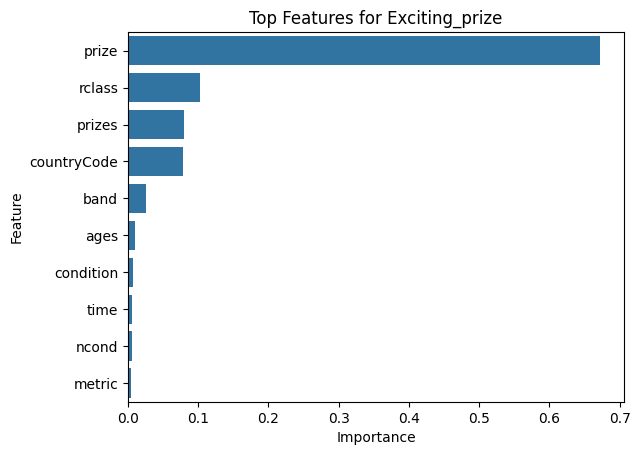

In [43]:
# 두 가지 방식 각각 학습 진행하여 다각도로 분석했다 !! 는 점을 발표에서 어필하면 도움이 될 것 같아요
# 1. target = prize 기준
races_df_prize = races_df.copy()
X = races_df_prize.drop(columns=['Exciting_prize', 'Exciting_class', 'Exciting_title', 'title', 'class', 'course', 'date'])
y = races_df_prize['Exciting_prize']

X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 각각의 피쳐 별 중요도 시각화
importances = model.feature_importances_
features = X_encoded.columns

feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

sns.barplot(data=feat_imp.head(10), x='Importance', y='Feature')
plt.title('Top Features for Exciting_prize')
plt.show()

In [44]:
# 2. target = title 기준
races_df_title = races_df.copy()
races_df_title['Exciting_title'] = races_df_title['title'].str.contains(
    'Cup|Championship|International', case=False, na=False
).astype(int)

print("🔥 타이틀 기준 흥행 여부 분포:")
print(races_df_title['Exciting_title'].value_counts(normalize=True))

🔥 타이틀 기준 흥행 여부 분포:
Exciting_title
0    0.973067
1    0.026933
Name: proportion, dtype: float64


In [45]:
# 모델이 불균형해서 언더샘플링 돌렸습니더
X = races_df_title.drop(columns=['Exciting_title'], errors='ignore')
y = races_df_title['Exciting_title']

from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

from sklearn.utils import resample
df_encoded = X_encoded.copy()
df_encoded['target'] = y

df_majority = df_encoded[df_encoded['target'] == 0]
df_minority = df_encoded[df_encoded['target'] == 1]

df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

X_bal = df_balanced.drop(columns=['target'])
y_bal = df_balanced['target']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print("📊 Classification Report (Exciting_title with undersampling):")
print(classification_report(y_test, y_pred))

📊 Classification Report (Exciting_title with undersampling):
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2141
           1       0.85      0.81      0.83      2132

    accuracy                           0.84      4273
   macro avg       0.84      0.84      0.84      4273
weighted avg       0.84      0.84      0.84      4273



In [ ]:
# 위와 같은 학습을 통해 accuracy 84%, F1-score 0.83 이상 확보

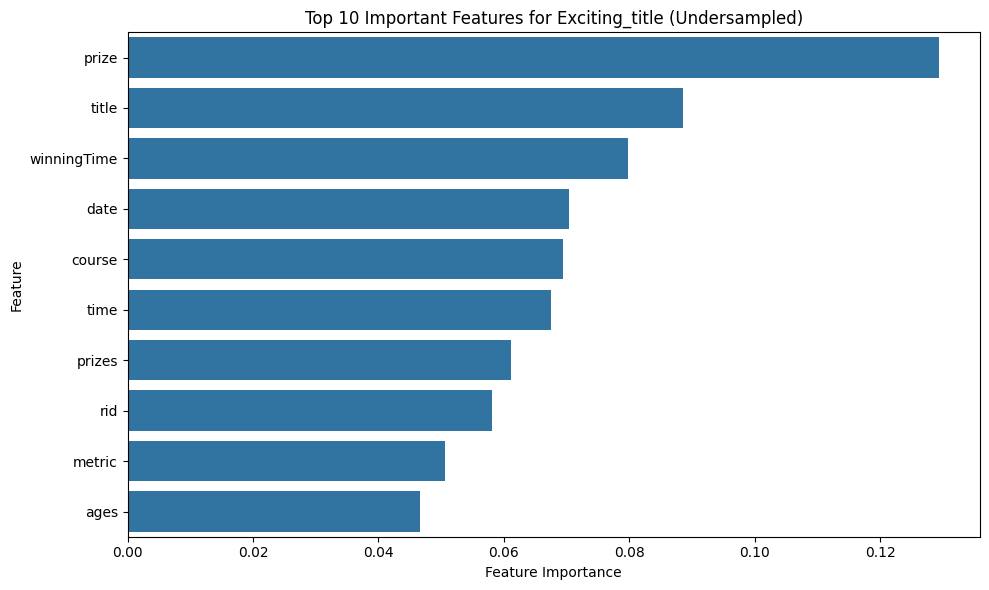

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = X_bal.columns

feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# 상위 10개 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features for Exciting_title (Undersampled)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [47]:
# 이로써 상금과 타이틀이 유의미한 상관관계를 지녔음이 증명됨!
# 다시 약간 앞으로 돌아가서 '국제 경마에서 우리나라 말이 좋은 성적을 거두기 위해 필요한 핵심 요인은 무엇인가?' 에 집중해보겠습니더...

In [48]:
horses_df_model = horses_df.copy()

# 우승과 관련된 타겟 지표 생성
horses_df_model['Win'] = (horses_df_model['position'] == 1).astype(int)

In [52]:
drop_cols = [
    'Win',
    'position',
    'decimalPrice',
    'margin',
    'res_win',
    'res_place',
    'price',
    'isFav',
    'positionL'
]

In [54]:
X = horses_df_model.drop(columns=drop_cols, errors='ignore')
y = horses_df_model['Win']

from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("🏆 Classification Report (우승 예측, 정제된 피처 기준):")
print(classification_report(y_test, y_pred))

🏆 Classification Report (우승 예측, 정제된 피처 기준):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1655
           1       0.47      0.15      0.23       111

    accuracy                           0.94      1766
   macro avg       0.71      0.57      0.60      1766
weighted avg       0.92      0.94      0.92      1766



In [55]:
# accuracy 자체는 높은데 recall이 나빠서 좋은 성능이 아님
# 얘도 언더샘플링 다시 해보기로

from sklearn.utils import resample
df_all = X_encoded.copy()
df_all['Win'] = y

df_major = df_all[df_all['Win'] == 0]  # 비우승
df_minor = df_all[df_all['Win'] == 1]  # 우승

df_major_down = resample(
    df_major,
    replace=False,
    n_samples=len(df_minor),
    random_state=42
)

df_balanced = pd.concat([df_major_down, df_minor])

X_bal = df_balanced.drop(columns=['Win'])
y_bal = df_balanced['Win']

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("🏆 Classification Report (언더샘플링 적용):")
print(classification_report(y_test, y_pred))

🏆 Classification Report (언더샘플링 적용):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       104
           1       0.95      0.99      0.97       102

    accuracy                           0.97       206
   macro avg       0.97      0.97      0.97       206
weighted avg       0.97      0.97      0.97       206



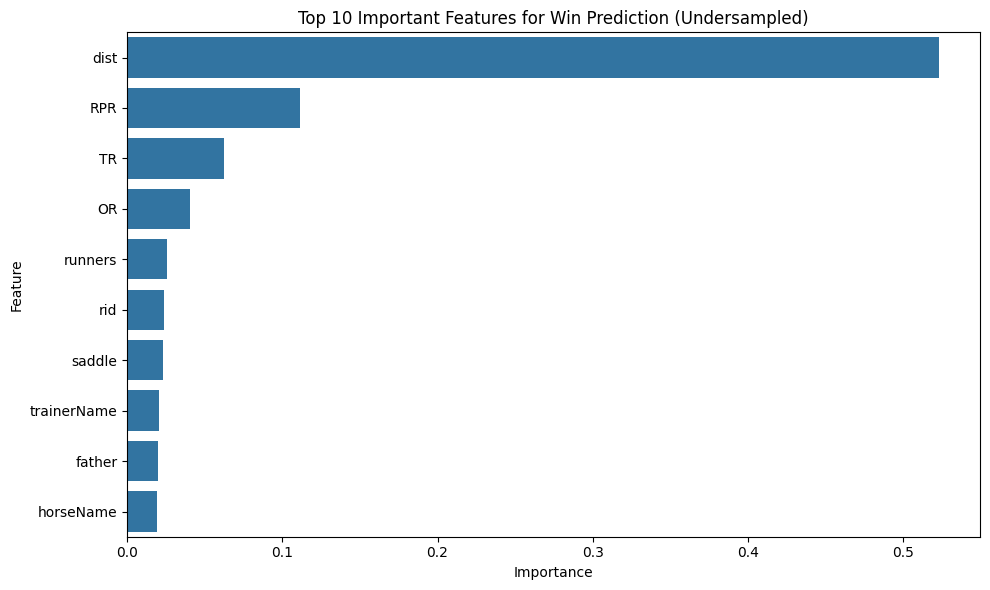

In [57]:
# accuracy 97%, recall도 유의미해짐!
# 시각화

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

importances = model.feature_importances_
features = X_bal.columns

feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features for Win Prediction (Undersampled)')
plt.tight_layout()
plt.show()

In [58]:
# 경기 거리(dist)가 압도적으로 중요하다는 결론이 도출됨
# 즉, 우리나라 말이 특정 거리(예: 1200m, 1400m)에서 더 강하다면 그에 집중된 전략 필요
# 또한, 전력지표와 조련사 등급? 조련사 평점??도 우승에 큰 영향을 미침

In [59]:
# 결론 !!
# 흥행과 관련된 요인 : 상금 규모, 타이틀
# 우승과 관련된 요인 : 경기 거리, Racing Post Rating (말 전력 지표), 조련사 실력